# Loading and converting INPOP ephemerides

## Standard imports

In [1]:
import sys, os, re, math, functools, pickle

In [2]:
from IPython.display import HTML, display
import tabulate

In [3]:
import numpy as np

import scipy.optimize as so
import scipy.linalg as sla
import scipy.integrate as si
import scipy.interpolate as sin

import matplotlib.pyplot as pp

%matplotlib inline

## Loading the partial files

Files are named by planet and planet coordinate with respect to which the partial is computed. Inside each partial, values are given in blocks of 13 lines: day from J2000 (+ 5 zeros), Mercury (equatorial x, y, z, vx, vy, vz), Venus (same), EMB (same), Mars (same), Jupiter (same), Saturn (same), Uranus (same), Neptune (same), Pluto (same), Moon relative to Earth (same), Sun relative to SSB (same), moon Libration angles (?).

In [12]:
!head -1 bayes_ephem_project/data/INPOP_partials/I1_AA110418amALKHQP_Jup_0_derivoutcar.dat

+0.000000000000000000000E+00	+0.000000000000000000000E+00	+0.000000000000000000000E+00	+0.000000000000000000000E+00	+0.000000000000000000000E+00	+0.000000000000000000000E+00


In [13]:
!head -2 bayes_ephem_project/data/INPOP_partials/I1_AA110418amALKHQP_Jup_0_derivoutcar.dat

+0.000000000000000000000E+00	+0.000000000000000000000E+00	+0.000000000000000000000E+00	+0.000000000000000000000E+00	+0.000000000000000000000E+00	+0.000000000000000000000E+00
-7.330854679470587796112E-04	-5.013889854243568783287E-04	-1.970525986239274156143E-04	-4.184973782041289183406E-07	+5.387932474596623293531E-07	+2.411419061038245137060E-07


In [31]:
jpart = np.zeros((6,2501,3),'d')

In [68]:
AU = 149597870.700
csec = 299792.458

In [157]:
for p in range(6):
    pj = np.loadtxt('bayes_ephem_project/data/INPOP_partials/I1_AA110418apALKHQP_Jup_{}_derivoutcar.dat'.format(p))
    
    # 11 is Sun
    jpart[p,:,:] = (AU / csec) * pj[11::13,:3] # s/[element dim]
    
ts = pj[::13,0]

In [111]:
# project out a polynomial
def project(x,y,degree=2):
    if degree is None:
        return x, None, y
    
    cs = np.polyfit(x,y,degree)
    ym = sum(c * x**(degree-i) for i,c in enumerate(cs))
    
    return x, ym, y-ym

In [112]:
j2000 = 51543.0 # check
mjd = j2000 + ts
jd = mjd + 2400000.5

Plot after removing linear trend

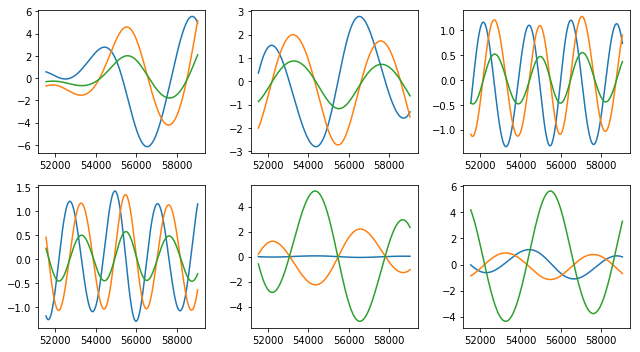

In [113]:
djpart = jpart.copy()

pp.figure(figsize=(9,5))

for p in range(6):
    pp.subplot(2,3,p+1)

    for i in range(3):
        x, ym, dm = project(mjd,jpart[p,:,i],degree=1)    
        djpart[p,:,i] = dm
        
        pp.plot(mjd,dm)

pp.tight_layout()

In [114]:
# make svd basis
def makesvd(rtp, rjpart, window=None, full_matrices=False):
    U, S, Vh = sla.svd(rjpart.reshape((rjpart.shape[0],rjpart.shape[1]*3)).copy(),full_matrices=False)
    jsvd = Vh.reshape((rjpart.shape[0],rjpart.shape[1],3)).copy()

    print(S)
    
    mult = rjpart.shape[0]/6
    
    pp.figure(figsize=(9,mult*5))

    for j in range(rjpart.shape[0]):
        pp.subplot(mult * 3,3,j+1)

        for i in range(3):
            if window:
                jsvd[j,:,i] = pd.rolling_mean(jsvd[j,:,i],window,center=True)
            
            pp.plot(rtp / 365.25 / 86400,
                    jsvd[j,:,i])

        # pp.axis(ymin=-0.03,ymax=0.03)

    pp.tight_layout()
    
    if full_matrices:
        return jsvd, S, U
    else:
        return jsvd, (np.diag(1/S) @ np.linalg.inv(U)).T

[243.87284772 174.14393348 156.29886397  64.10557532  60.9942879
  49.70856405]


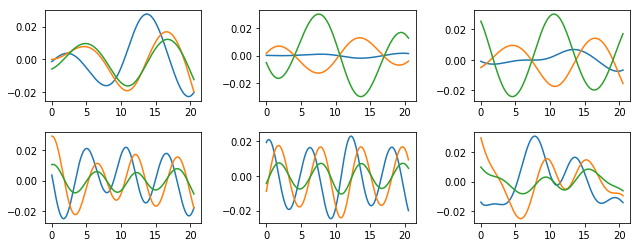

In [74]:
jsvd, cmat = makesvd((mjd - j2000)*86400,djpart,full_matrices=False)

In [75]:
os.mkdir('partials-export-20180420')

In [92]:
np.save('partials-export-20180420/jupiter-inpop-mjd.npy',mjd)
np.save('partials-export-20180420/jupiter-inpop-xyz.npy',jsvd)
np.save('partials-export-20180420/jupiter-inpop-cmat.npy',cmat)

In [93]:
!tar zcvf partials-export-20180420/jupiter-inpop.tar.gz partials-export-20180420/jupiter-inpop-*.npy

a partials-export-20180420/jupiter-inpop-cmat.npy
a partials-export-20180420/jupiter-inpop-mjd.npy
a partials-export-20180420/jupiter-inpop-xyz.npy


In [96]:
!cp partials-export-20180420/* bayes_ephem_project/data/inpop_partials/jupiter/.

## Examine Sun and Jupiter expected corrections as given by INPOP-provided Covariance matrix

In [97]:
inpopcov = np.loadtxt('bayes_ephem_project/data/INPOP_cov_matrix_planet.txt')

In [99]:
inpopcov.shape

(49, 49)

The covariance matrix is 49x49 and covers all planet orbits and solar mass. The order is

    ALKHQP_Ven ALKHQP_Mer ALKHQP_Mar ALKHQP_Jup ALKHQP_Sat ALKHQP_Ura ALKHQP_Nep ALKHQP_EMB

In [102]:
jupcov = inpopcov[3*6:(3+1)*6,3*6:(3+1)*6]

In [135]:
l = np.linalg.cholesky(jupcov)

def randp():
    de = np.dot(l, np.random.randn(6)) # I've checked this is the correct usage to get vectors with covariance APCOV1
    
    return np.einsum('ijk,i->jk',jpart,de) # s

Units of km. Too small.

/Users/vallis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


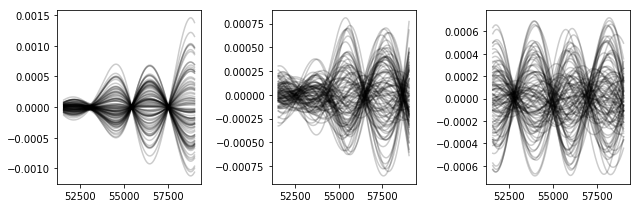

In [158]:
pp.figure(figsize=(9,3))

for n in range(100):
    p = randp()

    for i in range(3):
        pp.subplot(1,3,i+1)
        pp.plot(mjd,csec * p[:,i],'k',alpha=0.2)

pp.tight_layout()

### See Jupiter orbit corrections from Jup/Sat/Ura/Nep partials

The covariance matrix is 49x49 and covers all planet orbits and solar mass. The order is

    ALKHQP_Ven ALKHQP_Mer ALKHQP_Mar ALKHQP_Jup ALKHQP_Sat ALKHQP_Ura ALKHQP_Nep ALKHQP_EMB
    0:6        6:12       12:18      18:24      24:30      30:36      36:42    

In [149]:
gascov = inpopcov[18:42,18:42]
lg = np.linalg.cholesky(gascov)

Get Jupiter/Saturn/Uranus/Neptune partials on Jupiter (not Sun)

In [147]:
jjpart = np.zeros((6*4,2501,3),'d')

for iq,q in enumerate(["Jup","Sat","Ura","Nep"]):
    for p in range(6):
        pj = np.loadtxt('bayes_ephem_project/data/INPOP_partials/I1_AA110418apALKHQP_{}_{}_derivoutcar.dat'.format(q,p))

        ts = pj[::13,0]
        jjpart[iq*6+p,:,:] = (AU / csec) * pj[5::13,:3]

In [153]:
def randj():
    de = np.dot(lg, np.random.randn(24)) # I've checked this is the correct usage to get vectors with covariance APCOV1
    
    return np.einsum('ijk,i->jk',jjpart,de) # s

Again, too small.

/Users/vallis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


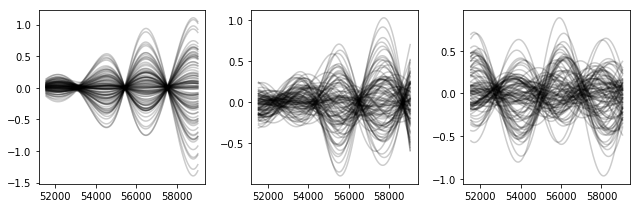

In [155]:
pp.figure(figsize=(9,3))

for n in range(100):
    p = randj()

    for i in range(3):
        pp.subplot(1,3,i+1)
        pp.plot(mjd,csec * p[:,i],'k',alpha=0.2)

pp.tight_layout()